In [1]:
import os

NUM_THREADS = "1"

os.environ["OMP_NUM_THREADS"] = NUM_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS
os.environ["MKL_NUM_THREADS"] = NUM_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,accuracy_score,precision_score,recall_score,classification_report
from sklearn.metrics import precision_recall_curve, auc, f1_score, fbeta_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.colors
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

##### Ignore Annoying Warnings

In [3]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
#
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action="ignore",category=ConvergenceWarning)

In [4]:
interp_str = 'INTERP'
outflow_str = 'outflow_avg'
fname_save = 'DATA/SHIPS_processed_ALL_BASINS_I_scaled_landmask_{interp_str}_{outflow_str}.csv'.format(interp_str=interp_str,
                                                                                    outflow_str=outflow_str)
SHIPS_load = pd.read_csv(fname_save)
SHIPS_load.columns

Index(['BASIN', 'ATCF ID', 'CASE', 'TIME', 'NAME', 'DATE_full', 'DTL', 'LAT',
       'SHRG', 'D200', 'Z850', 'VMAX', 'VMPI', 'PI_k', 'PI_cape', 'I_scaled k',
       'I_scaled cape', 'I_scaled', 'I_scaled orig', 'DELV', 'RHMD', 'NSST',
       'NOHC', 'DELV -12', 'RSST', 'RHCN', 'GOES Tb', 's(GOES Tb)',
       'pct < -50C', 'storm size', 'PC1', 'PC2', 'PC3', 'PC4'],
      dtype='object')

In [5]:
predictand = 'VMAX'
predictand2 = 'I_scaled'
predictand3 = 'I_scaled k'


Replace missing values and combine `RSST`/`NSST` and `NOHC`/`RHCN` into one variable

In [6]:
SHIPS_train = SHIPS_load.mask(SHIPS_load == 9999)
SHIPS_train = SHIPS_train.mask(SHIPS_train == 999.9)
SHIPS_train['SST'] = SHIPS_train['RSST']
SHIPS_train['OHC'] = SHIPS_train['RHCN']
#
SHIPS_train = SHIPS_train.set_index(['BASIN'])
SHIPS_train['SST'].loc['ATLANTIC'] = SHIPS_train['NSST'].loc['ATLANTIC']
SHIPS_train['SST'].loc['EAST_PACIFIC'] = SHIPS_train['NSST'].loc['EAST_PACIFIC']
#
SHIPS_train['SST'].loc['EAST_PACIFIC'] = SHIPS_train['NSST'].loc['EAST_PACIFIC']
SHIPS_train['OHC'].loc['ATLANTIC'] = SHIPS_train['NOHC'].loc['ATLANTIC']
SHIPS_train['OHC'].loc['EAST_PACIFIC'] = SHIPS_train['NOHC'].loc['EAST_PACIFIC']
SHIPS_train['Year'] = pd.to_datetime(SHIPS_train['DATE_full']).dt.year


### Save dataset for the NN 


In [7]:
index_columns = ['Year','BASIN','ATCF ID','CASE','TIME','NAME','DATE_full']
predictors_sel = ['DTL','LAT','SHRG','D200','Z850','RHMD','DELV -12','SST','OHC']
SHIPS_save = SHIPS_train.reset_index().set_index(index_columns)[predictors_sel]
SHIPS_save[['VMAX','I_scaled','I_scaled k']] = SHIPS_train.reset_index().set_index(index_columns)[['I_scaled',
                                                                                    'I_scaled k','VMAX']]
SHIPS_save = SHIPS_save.reset_index()
SHIPS_save.to_csv('CI_full_datat_save.csv')

#### Hyperparameters
* max_features = [4,5]
* max_depth = [5,6,8,11]
* min_samples_leaf = [10]
* n_estimators = [250]
##### Cross-val
* k_folds = 10
* n_repeats = 3

In [8]:
is_standard = True
score = ['squared_error']
max_features = [4,5]
max_depth = [5,6,8]
n_estimators = [100]
min_samples_leaf = [10,15]
n_splits = 5

In [9]:
def create_RF_regress(basin_train,basin_test,max_depth,score,max_features,n_estimators,min_samples_leaf,n_splits,
                     X_train,y_train,X_test,y_test):
    #
    X_train = X_train.xs(basin_train,level=1)
    y_train = y_train.xs(basin_train,level=1)
    #
    X_test = X_test.xs(basin_test,level=1)
    y_test = y_test.xs(basin_test,level=1)
    pipe = Pipeline([('scaler',StandardScaler()),('rm',RandomForestRegressor())])
    params = {'rm__max_depth':max_depth,
         'rm__criterion':score,
         'rm__max_features':max_features,
         'rm__n_estimators':n_estimators,
         'rm__min_samples_leaf':min_samples_leaf}
    #
    gridRF = GridSearchCV(pipe,param_grid=params,cv=KFold(n_splits = n_splits, shuffle=True))
    #
    gridRF.fit(X_train,y_train)
    #
    y_pred = gridRF.predict(X_test)
    rsq = r2_score(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    return y_pred,y_test,rsq,mse

Randomly select years for validation

In [10]:
SHIPS_test = SHIPS_train[SHIPS_train['Year']>=2018]
SHIPS_train = SHIPS_train[SHIPS_train['Year']<2018]
years_all = SHIPS_train['Year'].unique().tolist()
no_val_yrs = 3
N_samples = 15
#
rf_stats = pd.DataFrame(columns={'training basin','valid basin','MSE (I_scaled)','R^2  (I_scaled)',
                                      'MSE (I)','R^2 (I)','sample','validation yrs'},index=np.arange(0,1))
rf_res = pd.DataFrame(columns={'training basin','valid basin','y_pred (I_scaled)','y_truth  (I_scaled)',
                                      'y_pred (I)','y_truth (I)','sample','validation yrs'},index=np.arange(0,1))
#
for i in np.arange(0,N_samples):
    print('sample ',i)
    test_sel = random.sample(years_all,no_val_yrs)
    train_sel = list(set(years_all).difference(test_sel))
    print('validate on: ',test_sel)
    print('train on: ',train_sel)

    X_train = SHIPS_train.reset_index().set_index(index_columns).loc[train_sel]
    X_train_sel = X_train[predictors_sel]
    # 
    X_test = SHIPS_train.reset_index().set_index(index_columns).loc[test_sel]
    X_test_sel = X_test[predictors_sel]
    #
    pred_q = ['I_scaled k','VMAX']
    #
    y_train = SHIPS_train.reset_index().set_index(index_columns).loc[train_sel]
    y_train_sel = y_train[pred_q]
    X_train_use = X_train_sel.dropna(how='any')
    y_train_use = y_train_sel[y_train_sel.index.isin(X_train_use.index)]
    #
    y_test = SHIPS_train.reset_index().set_index(index_columns).loc[test_sel]
    y_test_sel = y_test[pred_q]

    X_test_use = X_test_sel.dropna(how='any')
    y_test_use = y_test_sel[y_test_sel.index.isin(X_test_use.index)]

    basin_all = X_train.reset_index()['BASIN'].unique().tolist()

    for i_basin_1 in basin_all:
        for i_basin_2 in basin_all:
            print('training on ',i_basin_1,', testing on ',i_basin_2)
            y_pred,y_test,rsq,mse = create_RF_regress(i_basin_1,i_basin_2,max_depth,score,max_features,n_estimators,min_samples_leaf,n_splits,
                         X_train_use,y_train_use['I_scaled k'],X_test_use,y_test_use['I_scaled k'])
            i_rf_stats = pd.DataFrame(columns={'training basin','valid basin','MSE (I_scaled)','R^2  (I_scaled)',
                                      'MSE (I)','R^2 (I)','sample','validation yrs'},index=np.arange(0,1))
            i_rf_stats['training basin'] = i_basin_1
            i_rf_stats['valid basin'] = i_basin_2
            i_rf_stats['MSE (I_scaled)'] = mse
            i_rf_stats['R^2 (I_scaled)'] = rsq
            #
            i_rf_res = pd.DataFrame(columns={'training basin','valid basin','y_pred (I_scaled)','y_truth  (I_scaled)',
                                      'y_pred (I)','y_truth (I)','sample','validation yrs'})
            i_rf_res['y_truth (I_scaled)'] = y_test
            i_rf_res['y_pred (I_scaled)'] = y_pred
            i_rf_res['training basin'] = i_basin_1
            i_rf_res['valid basin'] = i_basin_1
            i_rf_res['sample'] = i
            i_rf_stats['sample'] = i
            i_rf_res['validation yrs'] = str(test_sel)
            i_rf_stats['validation yrs'] = str(test_sel)
            ##
            y_pred_I,y_test_I,rsq_I,mse_I = create_RF_regress(i_basin_1,i_basin_2,max_depth,score,max_features,n_estimators,min_samples_leaf,n_splits,
                         X_train_use,y_train_use['VMAX'],X_test_use,y_test_use['VMAX'])
            i_rf_stats['MSE (I)'] = mse_I
            i_rf_stats['R^2 (I)'] = rsq_I
            i_rf_res['y_truth (I)'] = y_test_I
            i_rf_res['y_pred (I)'] = y_pred_I
            #
            rf_res = rf_res.append(i_rf_res,ignore_index=True)
            rf_stats = rf_stats.append(i_rf_stats,ignore_index=True)

sample  0
validate on:  [2015, 2006, 2009]
train on:  [2016, 2017, 2005, 2007, 2008, 2010, 2011, 2012, 2013, 2014]
training on  ATLANTIC , testing on  ATLANTIC
training on  ATLANTIC , testing on  EAST_PACIFIC
training on  ATLANTIC , testing on  WEST_PACIFIC
training on  ATLANTIC , testing on  SOUTHERN_HEM
training on  EAST_PACIFIC , testing on  ATLANTIC
training on  EAST_PACIFIC , testing on  EAST_PACIFIC
training on  EAST_PACIFIC , testing on  WEST_PACIFIC
training on  EAST_PACIFIC , testing on  SOUTHERN_HEM
training on  WEST_PACIFIC , testing on  ATLANTIC
training on  WEST_PACIFIC , testing on  EAST_PACIFIC
training on  WEST_PACIFIC , testing on  WEST_PACIFIC
training on  WEST_PACIFIC , testing on  SOUTHERN_HEM
training on  SOUTHERN_HEM , testing on  ATLANTIC
training on  SOUTHERN_HEM , testing on  EAST_PACIFIC
training on  SOUTHERN_HEM , testing on  WEST_PACIFIC
training on  SOUTHERN_HEM , testing on  SOUTHERN_HEM
sample  1
validate on:  [2010, 2016, 2015]
train on:  [2017, 2005, 20

KeyboardInterrupt: 

In [ ]:
fname_save_res = 'RF_model_ypred_{N}_samples_basin_gen_training_data_save_K-based_I.csv'.format(N=N_samples)
rf_res.to_csv(fname_save_res)
fname_save_stats = 'RF_model_STATS_{N}_samples_basin_gen_training_data_save_K-based_I.csv'.format(N=N_samples)
rf_stats.to_csv(fname_save_stats)

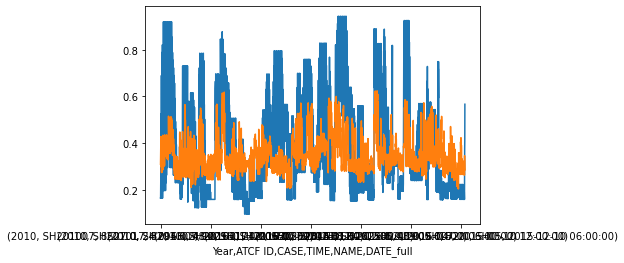

In [11]:
y_test.plot()
plt.plot(y_pred)

In [ ]:
N_samples = 15
RF_res = pd.read_csv('RF_model_ypred_{N}_samples_basin_gen_training_data_save_K-based_I.csv'.format(N=N_samples))
RF_stats = pd.read_csv('RF_model_STATS_{N}_samples_basin_gen_training_data_save_K-based_I.csv'.format(N=N_samples))

Text(0.5, 1.0, '$R^2$ Values During Model Training, 2005-2017')

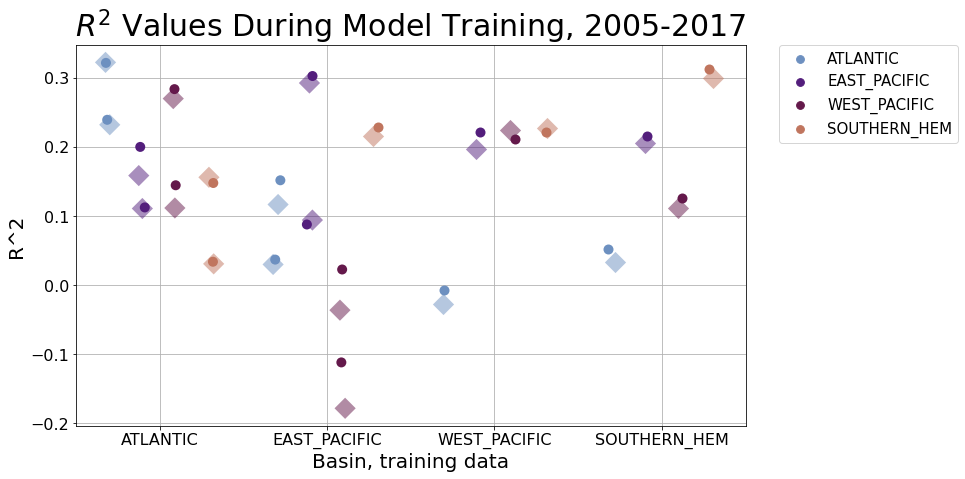

In [13]:
RF_stats = rf_stats
fig1,ax1 = plt.subplots(1,1,figsize=(12,7))
plt1 = sns.stripplot(data=RF_stats,x='training basin',y='R^2 (I)',hue='valid basin',dodge=True,s=10,
           palette='twilight')
plt2 = sns.stripplot(data=RF_stats,x='training basin',y='R^2 (I_scaled)',hue='valid basin',dodge=True,s=15,marker='D',
              palette='twilight',alpha=0.5)
ax1.set_xlabel('Basin, training data',fontsize=20)
ax1.tick_params(axis='both',labelsize=16)
ax1.set_ylabel('R^2',fontsize=20)
ax1.grid()
handles, labels = plt2.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
ax1.set_title('$R^2$ Values During Model Training, 2005-2017',fontsize=30)

In [ ]:
RF_stats